Compiling model...
Building feed-forward neural network...
'build' took 0.032314 s

'compile' took 0.340691 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.11e-04, 5.48e+09, 5.48e+09, 3.90e-06]    [2.11e-04, 5.48e+09, 5.48e+09, 3.90e-06]    []  
1000      [2.74e-02, 5.18e+09, 2.84e+09, 9.50e+03]    [2.74e-02, 5.18e+09, 2.84e+09, 9.50e+03]    []  
2000      [2.57e-03, 4.95e+09, 1.37e+09, 3.03e+04]    [2.57e-03, 4.95e+09, 1.37e+09, 3.03e+04]    []  
3000      [6.64e-04, 4.75e+09, 5.17e+08, 5.81e+04]    [6.64e-04, 4.75e+09, 5.17e+08, 5.81e+04]    []  
4000      [2.79e-04, 4.58e+09, 1.15e+08, 8.86e+04]    [2.79e-04, 4.58e+09, 1.15e+08, 8.86e+04]    []  
5000      [1.68e-04, 4.46e+09, 2.32e+06, 1.16e+05]    [1.67e-04, 4.46e+09, 2.32e+06, 1.16e+05]    []  
6000      [1.39e-04, 4.39e+09, 1.66e+07, 1.35e+05]    [1.39e-04, 4.39e+09, 1.66e+07, 1.35e+05]    []  
7000      [1.54e-04, 4.36e+09, 3.87e+07

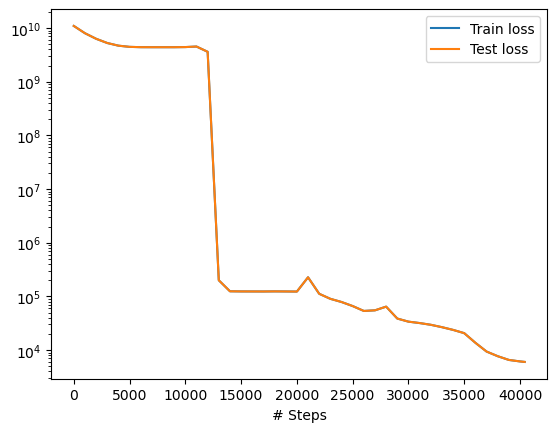

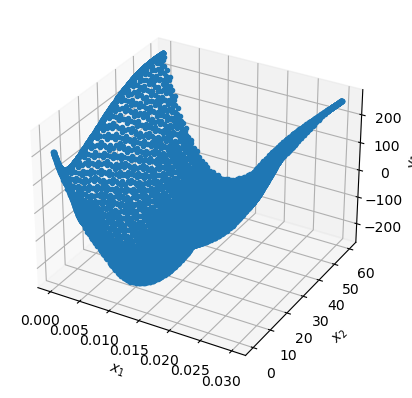

In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random as python_random

# Set random seed for reproducibility
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# problem parameters
k = 0.47
rho = 1573
c_p = 967
a = k / (rho * c_p)
h1 = 100
h2 = 10
u_inf = 323
L = 0.03

# pde

def heat_eq(x,y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a * dy_xx

# geometry and time domain

geom = dde.geometry.Interval(0,L)
timedomain = dde.geometry.TimeDomain(0,60)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_r (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],L)
def boundary_l (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0],0)


# Initial and boundary conditions
c =(h1/k)*u_inf 
bc_r = dde.icbc.RobinBC(geomtime, lambda X, u: c - (h1/k)*u , boundary_r, component=0)
bc_l = dde.icbc.RobinBC(geomtime, lambda X, u: c - (h2/k)*u , boundary_l, component=0)
ic = dde.icbc.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    heat_eq,
    [bc_l,bc_r, ic],
    num_domain=5000,
    num_boundary=285,
    num_initial=300,
)
layer_size = [2] + [90] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)  # Ensure the model is instantiated correctly

# Instantiate the PDEPointResampler callback
resampler = dde.callbacks.PDEPointResampler(period=100)

# Compile the model
model.compile("adam", lr=1e-3)

# Train the model with the resampler callback
model.train(iterations=5000, callbacks=[resampler])

# Further training with L-BFGS optimizer
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


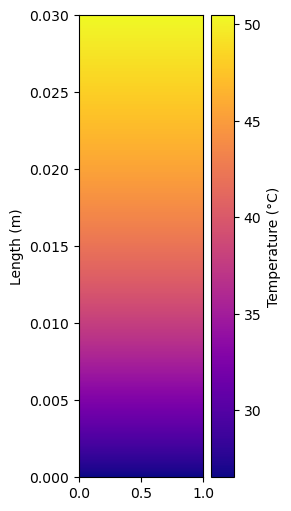

In [9]:

x = np.linspace(0, L, 400)
t = np.full_like(x,900)  # for t = 15 minutes, converted to seconds
X = np.vstack((x, t)).T

# Predict the temperature distribution using the trained model
u_pred = model.predict(X)

u_pred_celsius = u_pred - 273

# Plot the results in Celsius
plt.figure(figsize=(2, 6))
plt.imshow(u_pred_celsius.reshape((400, 1)), extent=[0, 1, 0, L], origin="lower", aspect="auto", cmap='plasma')
plt.colorbar(label='Temperature (°C)')
#plt.title("Temperature Distribution at t = 15 min")

plt.ylabel("Length (m)")
plt.show()